In [ ]:
#Run each cell step by step and save the 3 dataset files in same folder as the notebook
# Core Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
!pip install folium
import folium
from folium.plugins import HeatMap


from datetime import datetime
import warnings
warnings.filterwarnings('ignore') # Cleans up output by ignoring minor warnings

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6) # Default figure size

In [ ]:
# loading gps data for exploratory data analysis
df = pd.read_csv("/content/synthetic_gps_data.csv")

print("First 10 rows:")
display(df.head(10))


print(f"\nDataFrame Shape: {df.shape}")


print("\nColumn Info:")
print(df.info())


print("\nDescriptive Statistics:")
display(df.describe())


print("\nMissing Values per Column:")
print(df.isnull().sum())

First 10 rows:


,vehicle_id,timestamp,latitude,longitude,speed_kmph
0,VEH1534,2025-01-01 07:00:00,13.096422,77.531694,27.642101
1,VEH6204,2025-01-01 07:01:00,13.029275,77.675826,15.645618
2,VEH7085,2025-01-01 07:02:00,13.062871,77.634905,38.341273
3,VEH1365,2025-01-01 07:03:00,12.971242,77.506643,32.564501
4,VEH2915,2025-01-01 07:04:00,12.997467,77.596898,55.904479
5,VEH6579,2025-01-01 07:05:00,12.990437,77.698382,43.387981
6,VEH7728,2025-01-01 07:06:00,12.976625,77.521758,53.490243
7,VEH3416,2025-01-01 07:07:00,12.953571,77.636242,13.788753
8,VEH1085,2025-01-01 07:08:00,12.945559,77.542940,37.865712
9,VEH1898,2025-01-01 07:09:00,12.926816,77.665006,37.433796



DataFrame Shape: (1000, 5)

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   vehicle_id  1000 non-null   object 
 1   timestamp   1000 non-null   object 
 2   latitude    1000 non-null   float64
 3   longitude   1000 non-null   float64
 4   speed_kmph  1000 non-null   float64
dtypes: float64(3), object(2)
memory usage: 39.2+ KB
None

Descriptive Statistics:


,latitude,longitude,speed_kmph
count,1000.000000,1000.000000,1000.000000
mean,13.000208,77.600804,35.161631
std,0.057324,0.057616,9.994030
min,12.900147,77.500130,1.295126
25%,12.952384,77.553672,28.743845
50%,13.000829,77.600602,35.422296
75%,13.050404,77.650776,41.748581
max,13.099868,77.699443,70.219816



Missing Values per Column:
vehicle_id    0
timestamp     0
latitude      0
longitude     0
speed_kmph    0
dtype: int64


In [ ]:
# Creating the Speed Color Map
# Creating a colormap from blue (slow) to red (fast)
import branca.colormap as cm
import random
max_speed = df['speed_kmph'].max()
speed_colormap = cm.LinearColormap(
    colors=['darkblue', 'blue', 'green', 'yellow', 'orange', 'red'],
    vmin=0,
    vmax=max_speed,
    caption='Vehicle Speed'
)

print(f"Speed range: 0 to {max_speed:.2f}")

Speed range: 0 to 70.22


In [ ]:
# Feature Engineering for Traffic Prediction
import pandas as pd
import numpy as np
from datetime import datetime

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Create time-based features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek  # Monday=0, Sunday=6
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['is_rush_hour'] = ((df['hour'] >= 7) & (df['hour'] <= 10) | ((df['hour'] >= 16) & (df['hour'] <= 19))).astype(int)

# Create spatial grid (divide area into smaller regions)
df['lat_bin'] = (df['latitude'] * 100).round().astype(int)
df['lon_bin'] = (df['longitude'] * 100).round().astype(int)
df['grid_cell'] = df['lat_bin'].astype(str) + '_' + df['lon_bin'].astype(str)

# Calculate traffic density features
grid_traffic = df.groupby('grid_cell').agg({
    'vehicle_id': 'count',
    'speed_kmph': 'mean'
}).rename(columns={'vehicle_id': 'vehicle_count', 'speed_kmph': 'avg_speed'})

# Merge back with original data
df = df.merge(grid_traffic, on='grid_cell', how='left')

# Create target variable: High traffic areas (top 20% of vehicle density)
traffic_threshold = df['vehicle_count'].quantile(0.8)
df['high_traffic'] = (df['vehicle_count'] >= traffic_threshold).astype(int)

print("✅ Feature engineering completed!")
print(f"High traffic threshold: {traffic_threshold} vehicles per grid cell")
print(f"High traffic areas: {df['high_traffic'].sum()} data points")
display(df[['latitude', 'longitude', 'hour', 'is_rush_hour', 'vehicle_count', 'avg_speed', 'high_traffic']].head())

✅ Feature engineering completed!
High traffic threshold: 5.0 vehicles per grid cell
High traffic areas: 208 data points


,latitude,longitude,hour,is_rush_hour,vehicle_count,avg_speed,high_traffic
0,13.096422,77.531694,7,1,4,34.576592,0
1,13.029275,77.675826,7,1,3,40.098527,0
2,13.062871,77.634905,7,1,4,37.042270,0
3,12.971242,77.506643,7,1,5,32.642440,1
4,12.997467,77.596898,7,1,4,33.752722,0


In [ ]:
# @title Step 2: Prepare Data for Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Select features for prediction
features = ['latitude', 'longitude', 'hour', 'day_of_week', 'is_weekend', 'is_rush_hour']
X = df[features]
y = df['high_traffic']  # Target: 1 = high traffic, 0 = normal traffic

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("📊 Data preparation completed!")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"High traffic ratio: {y.mean():.2%}")

📊 Data preparation completed!
Training set: 800 samples
Test set: 200 samples
High traffic ratio: 20.80%


In [ ]:
# Train Multiple ML Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42)
}

results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\n🔧 Training {name}...")
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy_score(y_test, y_pred),
        'predictions': y_pred
    }

    print(f"✅ {name} Accuracy: {results[name]['accuracy']:.3f}")
    print(classification_report(y_test, y_pred))

# Find best model
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_model = results[best_model_name]['model']
print(f"\n🏆 Best Model: {best_model_name} with accuracy {results[best_model_name]['accuracy']:.3f}")


🔧 Training Random Forest...
✅ Random Forest Accuracy: 0.790
              precision    recall  f1-score   support

           0       0.82      0.94      0.88       158
           1       0.50      0.24      0.32        42

    accuracy                           0.79       200
   macro avg       0.66      0.59      0.60       200
weighted avg       0.75      0.79      0.76       200


🔧 Training Gradient Boosting...
✅ Gradient Boosting Accuracy: 0.780
              precision    recall  f1-score   support

           0       0.81      0.95      0.87       158
           1       0.43      0.14      0.21        42

    accuracy                           0.78       200
   macro avg       0.62      0.55      0.54       200
weighted avg       0.73      0.78      0.73       200


🔧 Training Logistic Regression...
✅ Logistic Regression Accuracy: 0.790
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       158
           1       0.00      0.00 

In [ ]:
# Visualizing Predicted High Traffic Areas
# Predict traffic for all locations
df['predicted_traffic'] = best_model.predict(scaler.transform(X))

# Create prediction map
prediction_map = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=12)

# Add actual high traffic areas
high_traffic_points = df[df['high_traffic'] == 1]
HeatMap(
    high_traffic_points[['latitude', 'longitude']].values.tolist(),
    radius=15,
    blur=10,
    max_zoom=1,
    gradient={0.4: 'blue', 0.6: 'green', 0.8: 'orange', 1: 'red'},
    name='Actual High Traffic'
).add_to(prediction_map)

# Add predicted high traffic areas
predicted_high_traffic = df[df['predicted_traffic'] == 1]
HeatMap(
    predicted_high_traffic[['latitude', 'longitude']].values.tolist(),
    radius=12,
    blur=8,
    max_zoom=1,
    gradient={0.4: 'purple', 0.6: 'pink', 0.8: 'magenta', 1: 'darkviolet'},
    name='Predicted High Traffic'
).add_to(prediction_map)

# Add layer control
folium.LayerControl().add_to(prediction_map)

print("🎯 Prediction Map Created!")
print("• Red areas: Actual high traffic locations")
print("• Purple areas: Predicted high traffic locations")
prediction_map

🎯 Prediction Map Created!
• Red areas: Actual high traffic locations
• Purple areas: Predicted high traffic locations


In [ ]:
# Load your gtfs data for predicting timing with maximum trafic
gfts_df = pd.read_csv("/content/synthetic_gtfs_data.csv") # Or use the direct path if using Google Drive

# 1.1. See the first 5-10 rows
print("First 10 rows:")
display(gfts_df.head(10))

# 1.2. Understand the DataFrame's shape (rows, columns)
print(f"\nDataFrame Shape: {gfts_df.shape}")

# 1.3. Get a list of all column names and their data types
print("\nColumn Info:")
print(gfts_df.info())

# 1.4. Generate descriptive statistics for numerical columns
print("\nDescriptive Statistics:")
display(gfts_df.describe())

# 1.5. Check for any missing values
print("\nMissing Values per Column:")
print(gfts_df.isnull().sum())

First 10 rows:


,trip_id,stop_id,scheduled_arrival,actual_arrival,delay_min
0,TRP1913,STP140,2025-01-01 07:00:00,2025-01-01 07:00:11.377011000,-0.589041
1,TRP1339,STP168,2025-01-01 07:01:00,2025-01-01 07:00:46.362177660,3.154271
2,TRP1471,STP195,2025-01-01 07:02:00,2025-01-01 07:06:41.918363820,0.873154
3,TRP1239,STP198,2025-01-01 07:03:00,2025-01-01 07:06:28.334876340,2.281778
4,TRP1414,STP117,2025-01-01 07:04:00,2025-01-01 07:07:58.157007960,1.549756
5,TRP1322,STP162,2025-01-01 07:05:00,2025-01-01 07:05:25.152996540,1.552330
6,TRP1322,STP162,2025-01-01 07:06:00,2025-01-01 07:08:35.674535760,2.201015
7,TRP1754,STP164,2025-01-01 07:07:00,2025-01-01 07:11:19.762142700,-0.395556
8,TRP1350,STP171,2025-01-01 07:08:00,2025-01-01 07:07:15.262393080,3.940860
9,TRP1838,STP129,2025-01-01 07:09:00,2025-01-01 07:08:21.785253060,1.356545



DataFrame Shape: (1000, 5)

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   trip_id            1000 non-null   object 
 1   stop_id            1000 non-null   object 
 2   scheduled_arrival  1000 non-null   object 
 3   actual_arrival     1000 non-null   object 
 4   delay_min          1000 non-null   float64
dtypes: float64(1), object(4)
memory usage: 39.2+ KB
None

Descriptive Statistics:


,delay_min
count,1000.000000
mean,2.014270
std,1.434416
min,-2.832626
25%,1.049437
50%,1.991633
75%,2.950760
max,7.546625



Missing Values per Column:
trip_id              0
stop_id              0
scheduled_arrival    0
actual_arrival       0
delay_min            0
dtype: int64


In [ ]:
# Finding Maximum Traffic Times from GTFS Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)



df = gfts_df

# Convert time columns to datetime
df['scheduled_arrival'] = pd.to_datetime(df['scheduled_arrival'])
df['actual_arrival'] = pd.to_datetime(df['actual_arrival'])

# @markdown ### **Calculate additional metrics:**
df['hour'] = df['scheduled_arrival'].dt.hour
df['time_period'] = pd.cut(df['hour'],
                          bins=[0, 6, 9, 12, 15, 18, 21, 24],
                          labels=['Late Night (0-6)', 'Morning Rush (6-9)',
                                 'Late Morning (9-12)', 'Afternoon (12-15)',
                                 'Evening Rush (15-18)', 'Evening (18-21)',
                                 'Night (21-24)'],
                          right=False)

df['day_of_week'] = df['scheduled_arrival'].dt.day_name()
df['is_weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)

print("✅ Data processing completed!")
print(f"Time range: {df['scheduled_arrival'].min()} to {df['scheduled_arrival'].max()}")
print(f"Total records: {len(df):,}")

✅ Data processing completed!
Time range: 2025-01-01 07:00:00 to 2025-01-01 23:39:00
Total records: 1,000


🚦 TOP 10 WORST TRAFFIC HOURS (by average delay):
 1. 07:00 - 2.3 min avg delay (60 trips)
 8. 14:00 - 2.3 min avg delay (60 trips)
17. 23:00 - 2.2 min avg delay (40 trips)
11. 17:00 - 2.1 min avg delay (60 trips)
 4. 10:00 - 2.1 min avg delay (60 trips)
 2. 08:00 - 2.1 min avg delay (60 trips)
 5. 11:00 - 2.1 min avg delay (60 trips)
 6. 12:00 - 2.0 min avg delay (60 trips)
13. 19:00 - 2.0 min avg delay (60 trips)
10. 16:00 - 2.0 min avg delay (60 trips)


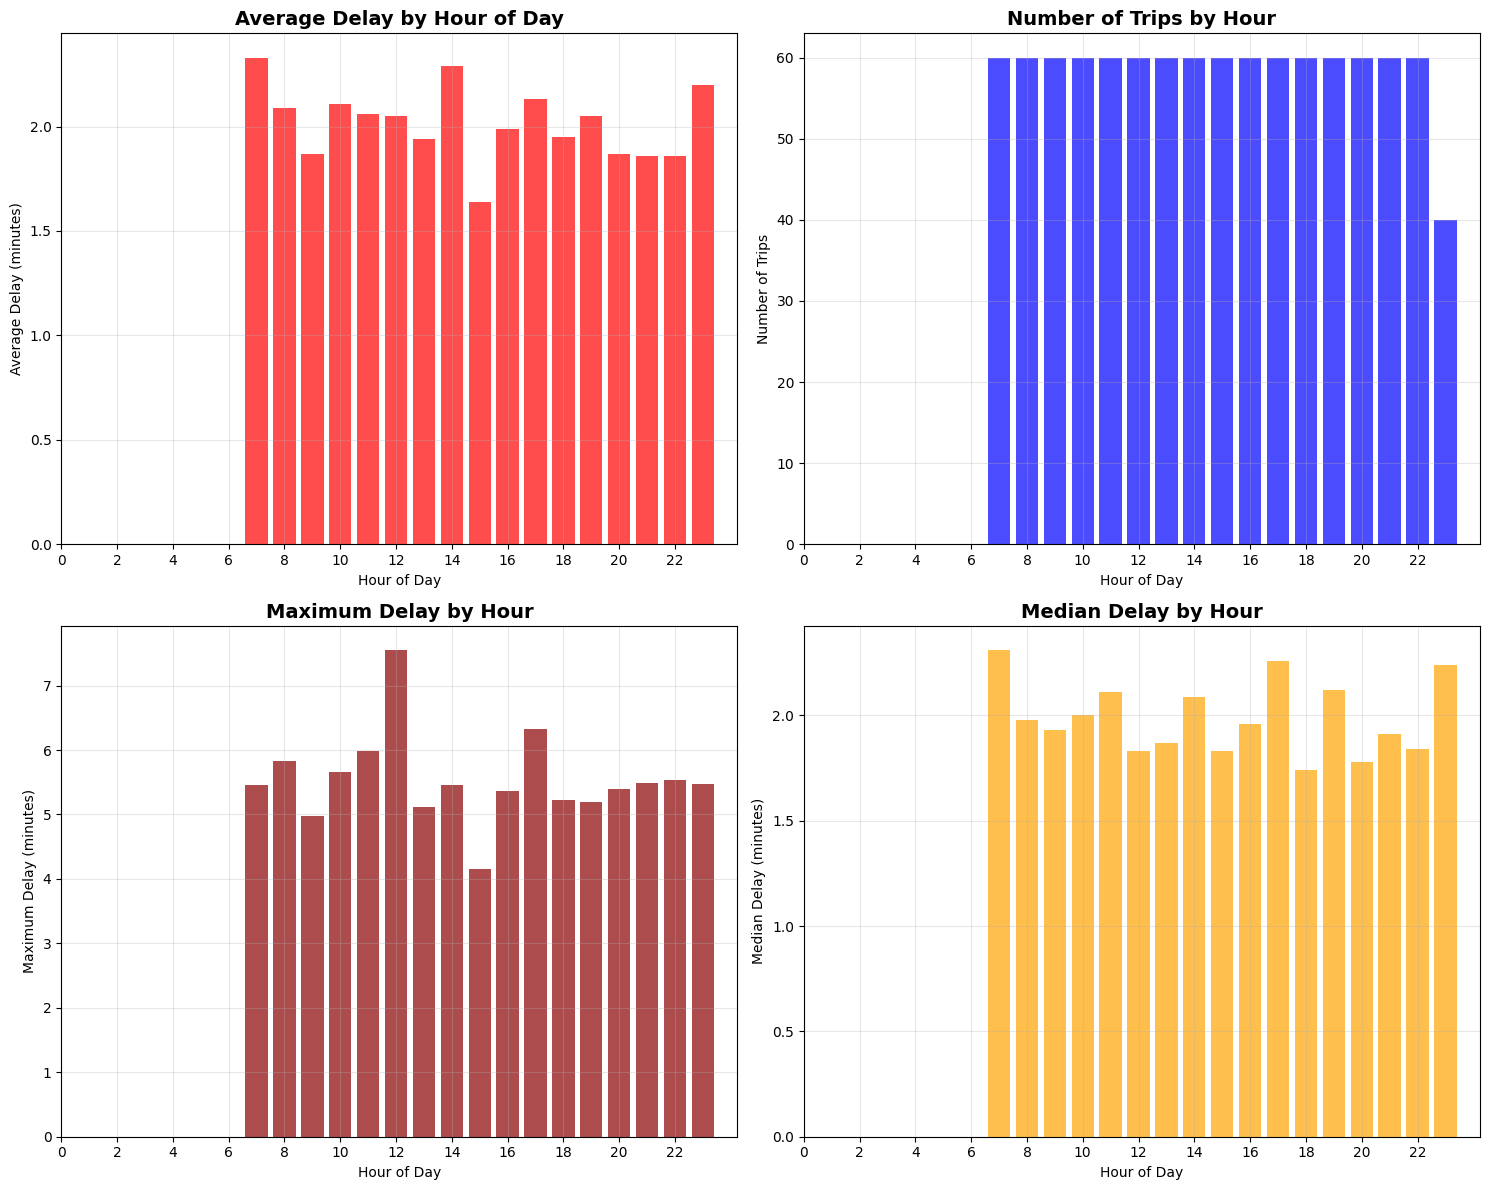

In [ ]:
# Analyzing Traffic Patterns by Hour (Fixed)
# Calculate hourly statistics
hourly_stats = df.groupby('hour').agg({
    'delay_min': ['mean', 'median', 'count', 'max'],
    'trip_id': 'nunique'
}).round(2)

hourly_stats.columns = ['avg_delay', 'median_delay', 'trip_count', 'max_delay', 'unique_trips']
hourly_stats = hourly_stats.reset_index()

# Find worst hours
worst_hours = hourly_stats.sort_values('avg_delay', ascending=False).head(10)

print("🚦 TOP 10 WORST TRAFFIC HOURS (by average delay):")
print("=" * 55)
for i, row in worst_hours.iterrows():
    print(f"{i+1:2d}. {int(row['hour']):02d}:00 - {row['avg_delay']:.1f} min avg delay "
          f"({int(row['trip_count'])} trips)")

# Visualize hourly patterns
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Average Delay by Hour
ax1.bar(hourly_stats['hour'], hourly_stats['avg_delay'], color='red', alpha=0.7)
ax1.set_title('Average Delay by Hour of Day', fontsize=14, fontweight='bold')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Average Delay (minutes)')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(0, 24, 2))

# Plot 2: Number of Trips by Hour
ax2.bar(hourly_stats['hour'], hourly_stats['trip_count'], color='blue', alpha=0.7)
ax2.set_title('Number of Trips by Hour', fontsize=14, fontweight='bold')
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('Number of Trips')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(range(0, 24, 2))

# Plot 3: Maximum Delay by Hour
ax3.bar(hourly_stats['hour'], hourly_stats['max_delay'], color='darkred', alpha=0.7)
ax3.set_title('Maximum Delay by Hour', fontsize=14, fontweight='bold')
ax3.set_xlabel('Hour of Day')
ax3.set_ylabel('Maximum Delay (minutes)')
ax3.grid(True, alpha=0.3)
ax3.set_xticks(range(0, 24, 2))

# Plot 4: Median Delay by Hour
ax4.bar(hourly_stats['hour'], hourly_stats['median_delay'], color='orange', alpha=0.7)
ax4.set_title('Median Delay by Hour', fontsize=14, fontweight='bold')
ax4.set_xlabel('Hour of Day')
ax4.set_ylabel('Median Delay (minutes)')
ax4.grid(True, alpha=0.3)
ax4.set_xticks(range(0, 24, 2))

plt.tight_layout()
plt.show()

🕒 TRAFFIC BY TIME PERIOD:
Late Night (0-6): nan min avg delay (0 trips)
Morning Rush (6-9): 2.2 min avg delay (120 trips)
Late Morning (9-12): 2.0 min avg delay (180 trips)
Afternoon (12-15): 2.1 min avg delay (180 trips)
Evening Rush (15-18): 1.9 min avg delay (180 trips)
Evening (18-21): 2.0 min avg delay (180 trips)
Night (21-24): 1.9 min avg delay (160 trips)


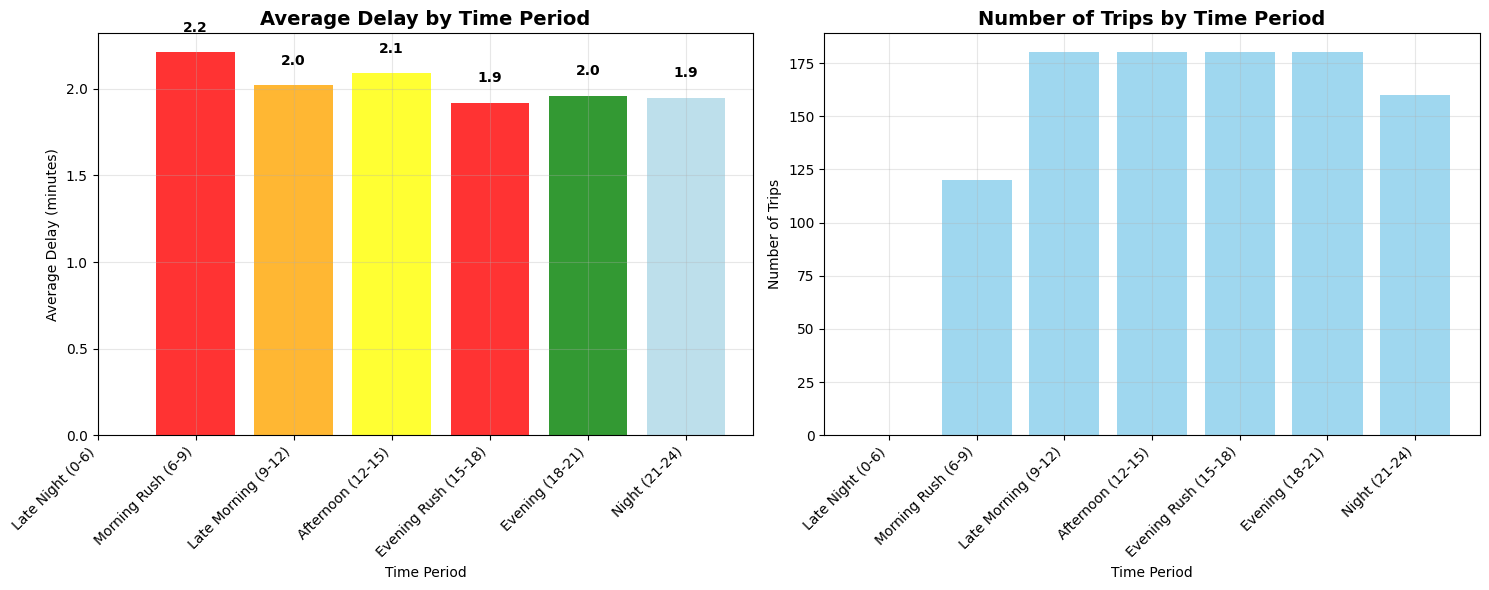

In [ ]:
# Analyzing by Time Period Categories (Fixed)
# Calculate statistics by time period
period_stats = df.groupby('time_period').agg({
    'delay_min': ['mean', 'median', 'count', 'max'],
    'trip_id': 'nunique'
}).round(2)

period_stats.columns = ['avg_delay', 'median_delay', 'trip_count', 'max_delay', 'unique_trips']
period_stats = period_stats.reset_index()

print("🕒 TRAFFIC BY TIME PERIOD:")
print("=" * 40)
for i, row in period_stats.iterrows():
    print(f"{row['time_period']}: {row['avg_delay']:.1f} min avg delay "
          f"({int(row['trip_count'])} trips)")

# Visualize by time period
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Average Delay by Time Period
colors = ['lightblue', 'red', 'orange', 'yellow', 'red', 'green', 'lightblue']
bars = ax1.bar(range(len(period_stats)), period_stats['avg_delay'], color=colors, alpha=0.8)
ax1.set_title('Average Delay by Time Period', fontsize=14, fontweight='bold')
ax1.set_xlabel('Time Period')
ax1.set_ylabel('Average Delay (minutes)')
ax1.set_xticks(range(len(period_stats)))
ax1.set_xticklabels(period_stats['time_period'], rotation=45, ha='right')
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, period_stats['avg_delay']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{value:.1f}', ha='center', va='bottom', fontweight='bold')

# Trip Count by Time Period
ax2.bar(range(len(period_stats)), period_stats['trip_count'], color='skyblue', alpha=0.8)
ax2.set_title('Number of Trips by Time Period', fontsize=14, fontweight='bold')
ax2.set_xlabel('Time Period')
ax2.set_ylabel('Number of Trips')
ax2.set_xticks(range(len(period_stats)))
ax2.set_xticklabels(period_stats['time_period'], rotation=45, ha='right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

📈 DETAILED HOURLY TRAFFIC ANALYSIS:
Hour |  Avg  | Median |  Max  | 90th %ile | Trips
-------------------------------------------------------
 7:00 |   2.3 |    2.3 |   5.5 |      4.1 |    60
 8:00 |   2.1 |    2.0 |   5.8 |      3.7 |    60
 9:00 |   1.9 |    1.9 |   5.0 |      3.5 |    60
10:00 |   2.1 |    2.0 |   5.7 |      4.1 |    60
11:00 |   2.1 |    2.1 |   6.0 |      3.4 |    60
12:00 |   2.0 |    1.8 |   7.5 |      4.0 |    60
13:00 |   1.9 |    1.9 |   5.1 |      3.7 |    60
14:00 |   2.3 |    2.1 |   5.5 |      4.1 |    60
15:00 |   1.6 |    1.8 |   4.2 |      3.0 |    60
16:00 |   2.0 |    2.0 |   5.4 |      4.1 |    60
17:00 |   2.1 |    2.3 |   6.3 |      3.7 |    60
18:00 |   1.9 |    1.7 |   5.2 |      3.9 |    60
19:00 |   2.0 |    2.1 |   5.2 |      3.5 |    60
20:00 |   1.9 |    1.8 |   5.4 |      3.7 |    60
21:00 |   1.9 |    1.9 |   5.5 |      3.5 |    60
22:00 |   1.9 |    1.8 |   5.5 |      3.5 |    60
23:00 |   2.2 |    2.2 |   5.5 |      4.3 |    40


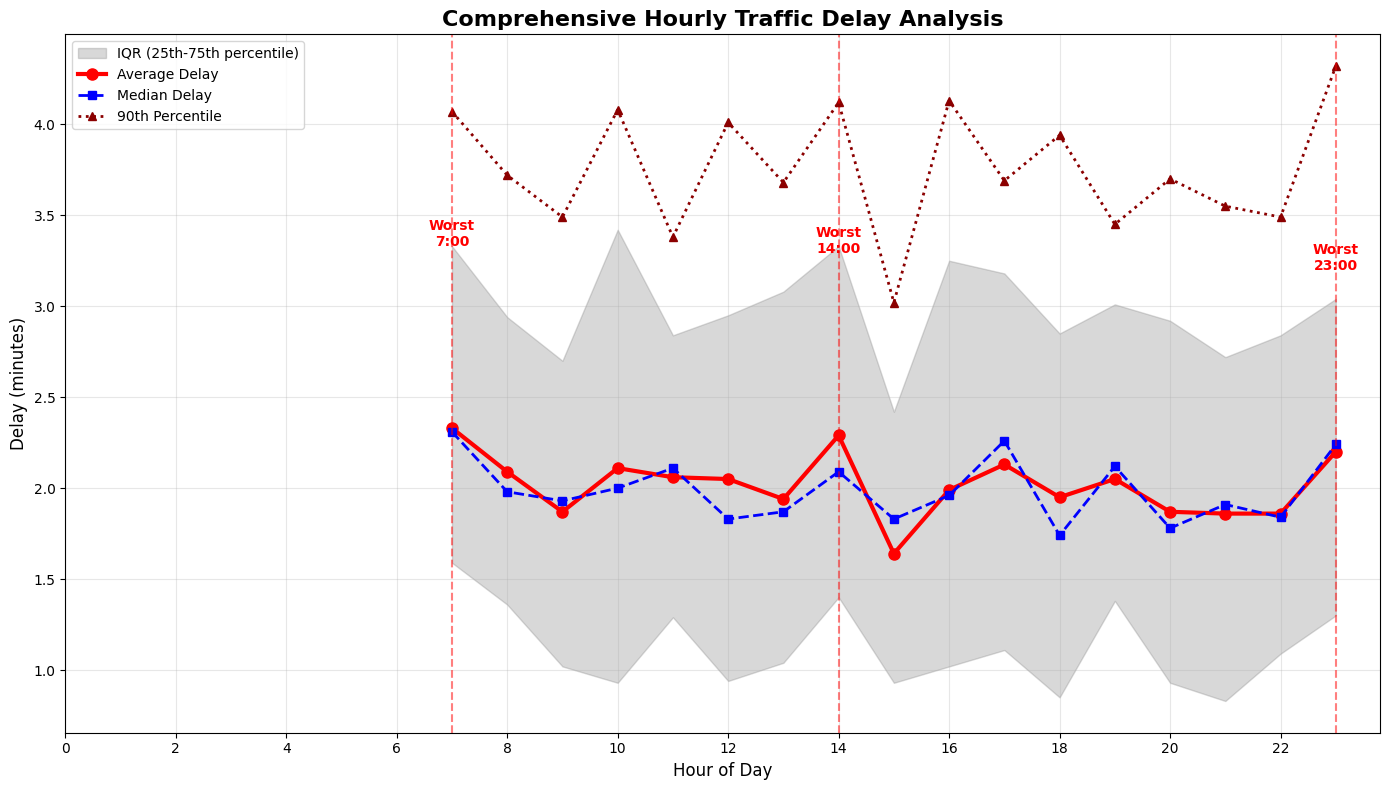

In [ ]:
# Detailed Hourly Analysis with Percentiles (Fixed)
# Calculate detailed hourly statistics
hourly_detailed = df.groupby('hour')['delay_min'].agg([
    'mean', 'median', 'count', 'max', 'min',
    lambda x: x.quantile(0.25),  # Q1
    lambda x: x.quantile(0.75),  # Q3
    lambda x: x.quantile(0.90)   # 90th percentile
]).round(2)

hourly_detailed.columns = ['avg_delay', 'median_delay', 'count', 'max_delay',
                          'min_delay', 'q1', 'q3', 'p90']
hourly_detailed = hourly_detailed.reset_index()

print("📈 DETAILED HOURLY TRAFFIC ANALYSIS:")
print("=" * 50)
print("Hour |  Avg  | Median |  Max  | 90th %ile | Trips")
print("-" * 55)
for i, row in hourly_detailed.iterrows():
    print(f"{int(row['hour']):2d}:00 | {row['avg_delay']:5.1f} | {row['median_delay']:6.1f} | "
          f"{row['max_delay']:5.1f} | {row['p90']:8.1f} | {int(row['count']):5}")

# Create a comprehensive visualization
plt.figure(figsize=(14, 8))

# Plot with percentiles
hours = hourly_detailed['hour']
plt.fill_between(hours, hourly_detailed['q1'], hourly_detailed['q3'],
                alpha=0.3, color='gray', label='IQR (25th-75th percentile)')
plt.plot(hours, hourly_detailed['avg_delay'], 'o-', linewidth=3,
         markersize=8, color='red', label='Average Delay')
plt.plot(hours, hourly_detailed['median_delay'], 's--', linewidth=2,
         markersize=6, color='blue', label='Median Delay')
plt.plot(hours, hourly_detailed['p90'], '^:', linewidth=2,
         markersize=6, color='darkred', label='90th Percentile')

plt.title('Comprehensive Hourly Traffic Delay Analysis', fontsize=16, fontweight='bold')
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Delay (minutes)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24, 2))

# Highlight worst hours
worst_3_hours = hourly_detailed.nlargest(3, 'avg_delay')
for _, row in worst_3_hours.iterrows():
    plt.axvline(x=row['hour'], color='red', linestyle='--', alpha=0.5)
    plt.text(row['hour'], row['avg_delay'] + 1, f"Worst\n{int(row['hour'])}:00",
             ha='center', fontweight='bold', color='red')

plt.tight_layout()
plt.show()

In [ ]:
# @title Final Summary: Maximum Traffic Times (Fixed)
# Identify peak congestion periods
peak_congestion = hourly_detailed.nlargest(5, 'avg_delay')

print("🚨 MAXIMUM TRAFFIC TIMES IDENTIFIED")
print("=" * 40)
print("Based on historical delay patterns:\n")

for i, (_, row) in enumerate(peak_congestion.iterrows(), 1):
    hour = int(row['hour'])
    avg_delay = row['avg_delay']
    median_delay = row['median_delay']
    p90_delay = row['p90']

    # Categorize severity
    if avg_delay > 15:
        severity = "🚨 SEVERE CONGESTION"
    elif avg_delay > 10:
        severity = "🔴 HEAVY TRAFFIC"
    elif avg_delay > 5:
        severity = "🟠 MODERATE TRAFFIC"
    else:
        severity = "🟢 LIGHT TRAFFIC"

    print(f"{i}. {hour:02d}:00 - {severity}")
    print(f"   Average delay: {avg_delay:.1f} minutes")
    print(f"   Median delay: {median_delay:.1f} minutes")
    print(f"   90% of trips delayed by: ≤ {p90_delay:.1f} minutes")
    print(f"   Total trips: {int(row['count'])}")
    print()

print("💡 RECOMMENDATIONS:")
print("- Avoid travel during peak congestion hours if possible")
print("- Add extra time for journeys during these periods")
print("- Consider alternative routes or transportation modes")
print("- Morning and evening rush hours typically show highest delays")

🚨 MAXIMUM TRAFFIC TIMES IDENTIFIED
Based on historical delay patterns:

1. 07:00 - 🟢 LIGHT TRAFFIC
   Average delay: 2.3 minutes
   Median delay: 2.3 minutes
   90% of trips delayed by: ≤ 4.1 minutes
   Total trips: 60

2. 14:00 - 🟢 LIGHT TRAFFIC
   Average delay: 2.3 minutes
   Median delay: 2.1 minutes
   90% of trips delayed by: ≤ 4.1 minutes
   Total trips: 60

3. 23:00 - 🟢 LIGHT TRAFFIC
   Average delay: 2.2 minutes
   Median delay: 2.2 minutes
   90% of trips delayed by: ≤ 4.3 minutes
   Total trips: 40

4. 17:00 - 🟢 LIGHT TRAFFIC
   Average delay: 2.1 minutes
   Median delay: 2.3 minutes
   90% of trips delayed by: ≤ 3.7 minutes
   Total trips: 60

5. 10:00 - 🟢 LIGHT TRAFFIC
   Average delay: 2.1 minutes
   Median delay: 2.0 minutes
   90% of trips delayed by: ≤ 4.1 minutes
   Total trips: 60

💡 RECOMMENDATIONS:
- Avoid travel during peak congestion hours if possible
- Add extra time for journeys during these periods
- Consider alternative routes or transportation modes
- Mornin

In [ ]:
# Analysing sensor data for exploring no of cars, trafic and speed trends
sens_df = pd.read_csv("/content/synthetic_sensor_data.csv")

# 1.1. See the first 5-10 rows
print("First 10 rows:")
display(sens_df.head(10))

# 1.2. Understand the DataFrame's shape (rows, columns)
print(f"\nDataFrame Shape: {sens_df.shape}")

# 1.3. Get a list of all column names and their data types
print("\nColumn Info:")
print(sens_df.info())

# 1.4. Generate descriptive statistics for numerical columns
print("\nDescriptive Statistics:")
display(gfts_df.describe())

# 1.5. Check for any missing values
print("\nMissing Values per Column:")
print(gfts_df.isnull().sum())

First 10 rows:


,sensor_id,timestamp,vehicle_count,avg_speed
0,SEN121,2025-01-01 07:00:00,5,33.107702
1,SEN150,2025-01-01 07:01:00,9,37.791548
2,SEN168,2025-01-01 07:02:00,11,39.069640
3,SEN175,2025-01-01 07:03:00,11,50.539776
4,SEN128,2025-01-01 07:04:00,16,40.600515
5,SEN159,2025-01-01 07:05:00,8,34.739561
6,SEN110,2025-01-01 07:06:00,15,39.462216
7,SEN171,2025-01-01 07:07:00,7,40.555016
8,SEN191,2025-01-01 07:08:00,16,42.982312
9,SEN199,2025-01-01 07:09:00,10,34.579034



DataFrame Shape: (1000, 4)

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sensor_id      1000 non-null   object 
 1   timestamp      1000 non-null   object 
 2   vehicle_count  1000 non-null   int64  
 3   avg_speed      1000 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 31.4+ KB
None

Descriptive Statistics:


,scheduled_arrival,actual_arrival,delay_min,hour,is_weekend
count,1000,1000,1000.000000,1000.000000,1000.0
mean,2025-01-01 15:19:30,2025-01-01 15:21:26.605873152,2.014270,14.840000,0.0
min,2025-01-01 07:00:00,2025-01-01 07:00:11.377011,-2.832626,7.000000,0.0
25%,2025-01-01 11:09:45,2025-01-01 11:11:12.396679936,1.049437,11.000000,0.0
50%,2025-01-01 15:19:30,2025-01-01 15:20:43.675500544,1.991633,15.000000,0.0
75%,2025-01-01 19:29:15,2025-01-01 19:31:05.189098752,2.950760,19.000000,0.0
max,2025-01-01 23:39:00,2025-01-01 23:41:26.442192660,7.546625,23.000000,0.0
std,NaN,NaN,1.434416,4.816388,0.0



Missing Values per Column:
trip_id              0
stop_id              0
scheduled_arrival    0
actual_arrival       0
delay_min            0
hour                 0
time_period          0
day_of_week          0
is_weekend           0
dtype: int64


In [ ]:
# LOADING ALL THREE DATASETS for the trafic optimastion machine learning predictor training
print("📂 LOADING ALL DATASETS")
print("=" * 40)

# @markdown ### **Upload GPS Data (vehicle trajectories):**
gps_df = pd.read_csv("/content/synthetic_gps_data.csv")

# @markdown ### **Upload GTFS Data (public transport delays):**
gtfs_df = pd.read_csv("/content/synthetic_gtfs_data.csv")

# @markdown ### **Upload Sensor Data (traffic measurements):**
sensor_df = pd.read_csv("/content/synthetic_sensor_data.csv")



📂 LOADING ALL DATASETS


In [ ]:
# @title STEP 2: DATA PREPROCESSING
print("🔧 DATA PREPROCESSING - FIXED")
print("=" * 45)

# Convert timestamps
gps_df['timestamp'] = pd.to_datetime(gps_df['timestamp'])
gtfs_df['scheduled_arrival'] = pd.to_datetime(gtfs_df['scheduled_arrival'])
gtfs_df['actual_arrival'] = pd.to_datetime(gtfs_df['actual_arrival'])
sensor_df['timestamp'] = pd.to_datetime(sensor_df['timestamp'])

# Calculate delay for GTFS
gtfs_df['delay_min'] = (gtfs_df['actual_arrival'] - gtfs_df['scheduled_arrival']).dt.total_seconds() / 60

print("✅ Timestamps converted and delay calculated!")

# Extract time features
gps_df['hour'] = gps_df['timestamp'].dt.hour
gps_df['day_of_week'] = gps_df['timestamp'].dt.dayofweek

gtfs_df['hour'] = gtfs_df['scheduled_arrival'].dt.hour
gtfs_df['day_of_week'] = gtfs_df['scheduled_arrival'].dt.dayofweek

sensor_df['hour'] = sensor_df['timestamp'].dt.hour
sensor_df['day_of_week'] = sensor_df['timestamp'].dt.dayofweek

print("✅ Time features extracted!")

🔧 DATA PREPROCESSING - FIXED
✅ Timestamps converted and delay calculated!
✅ Time features extracted!


In [ ]:
# @title STEP 3: SPATIAL ANALYSIS FOR GPS DATA ONLY
print("🗺️ SPATIAL ANALYSIS (GPS DATA ONLY)")
print("=" * 45)

# Create spatial grid for GPS data
gps_df['grid_lat'] = (gps_df['latitude'] * 100).round(2)
gps_df['grid_lon'] = (gps_df['longitude'] * 100).round(2)
gps_df['grid_id'] = gps_df['grid_lat'].astype(str) + '_' + gps_df['grid_lon'].astype(str)

print(f"📍 GPS grid cells created: {gps_df['grid_id'].nunique()}")

# Analyze GPS traffic patterns
gps_hourly = gps_df.groupby(['grid_id', 'hour']).agg({
    'speed_kmph': ['mean', 'std', 'count'],
    'vehicle_id': 'nunique'
}).round(2)

gps_hourly.columns = ['avg_speed', 'speed_std', 'point_count', 'vehicle_count']
gps_hourly = gps_hourly.reset_index()

print("📊 GPS Hourly Statistics:")
display(gps_hourly.head())

# Create base grid-hour matrix
all_grids = gps_df['grid_id'].unique()
all_hours = range(24)

feature_data = []
for grid_id in all_grids:
    for hour in all_hours:
        lat, lon = map(float, grid_id.split('_'))
        feature_data.append({
            'grid_id': grid_id,
            'hour': hour,
            'lat': lat / 100,
            'lon': lon / 100
        })

features_df = pd.DataFrame(feature_data)

# Merge GPS features
features_df = features_df.merge(gps_hourly, on=['grid_id', 'hour'], how='left')

# Fill missing values
features_df = features_df.fillna({
    'avg_speed': features_df['avg_speed'].median(),
    'speed_std': 0,
    'point_count': 0,
    'vehicle_count': 0
})

print("✅ Feature matrix created! Shape:", features_df.shape)

🗺️ SPATIAL ANALYSIS (GPS DATA ONLY)
📍 GPS grid cells created: 1000
📊 GPS Hourly Statistics:


,grid_id,hour,avg_speed,speed_std,point_count,vehicle_count
0,1290.01_7750.69,8,33.50,NaN,1,1
1,1290.03_7768.09,23,52.41,NaN,1,1
2,1290.04_7765.57,15,23.50,NaN,1,1
3,1290.11_7769.58,22,36.46,NaN,1,1
4,1290.12_7769.29,18,26.83,NaN,1,1


✅ Feature matrix created! Shape: (24000, 8)


In [ ]:
# @title STEP 4: CREATE TARGET VARIABLE
print("🎯 CREATING TARGET VARIABLE")
print("=" * 40)

def calculate_congestion_score(row):
    score = 0

    # Speed-based congestion
    speed_penalty = max(0, 40 - row['avg_speed']) * 2
    score += min(speed_penalty, 50)

    # Volume-based congestion
    volume_penalty = min(row['vehicle_count'] / 5, 30)
    score += volume_penalty

    # Consistency penalty (high std deviation)
    if row['speed_std'] > 15:
        score += 20

    return min(score, 100)

features_df['congestion_score'] = features_df.apply(calculate_congestion_score, axis=1)
features_df['congestion_level'] = pd.cut(features_df['congestion_score'],
                                        bins=[0, 20, 40, 60, 80, 100],
                                        labels=['Free Flow', 'Light', 'Moderate', 'Heavy', 'Severe'])

print("📊 Congestion Distribution:")
print(features_df['congestion_level'].value_counts())

🎯 CREATING TARGET VARIABLE
📊 Congestion Distribution:
congestion_level
Free Flow    23687
Light          244
Moderate        69
Heavy            0
Severe           0
Name: count, dtype: int64


In [ ]:
# @title STEP 5: TRAIN ML MODEL
print("🤖 TRAINING ML MODEL")
print("=" * 35)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score


# Feature selection
feature_columns = ['hour', 'lat', 'lon', 'avg_speed', 'speed_std', 'vehicle_count']

X = features_df[feature_columns].fillna(0)
y = features_df['congestion_score']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

print(f"✅ Model trained! MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred):.3f}")

🤖 TRAINING ML MODEL
✅ Model trained! MAE: 0.00
R² Score: 1.000


In [ ]:
# @title STEP 6: PREDICTION FUNCTION
print("🔮 PREDICTION FUNCTION")
print("=" * 35)

def predict_congestion(latitude, longitude, hour):
    # Prepare features
    features = {
        'hour': hour,
        'lat': latitude,
        'lon': longitude,
        'avg_speed': features_df['avg_speed'].median(),
        'speed_std': 0,
        'vehicle_count': features_df['vehicle_count'].median()
    }

    # Predict
    feature_df = pd.DataFrame([features])[feature_columns]
    prediction = model.predict(feature_df)[0]

    # Classify
    if prediction < 20:
        level = "🟢 FREE FLOW"
    elif prediction < 40:
        level = "🟡 LIGHT CONGESTION"
    elif prediction < 60:
        level = "🟠 MODERATE CONGESTION"
    elif prediction < 80:
        level = "🔴 HEAVY CONGESTION"
    else:
        level = "🚨 SEVERE CONGESTION"

    return prediction, level

# Test prediction
test_lat, test_lon, test_hour = gps_df['latitude'].mean(), gps_df['longitude'].mean(), 18
score, level = predict_congestion(test_lat, test_lon, test_hour)
print(f"📍 ({test_lat:.4f}, {test_lon:.4f}) at {test_hour}:00")
print(f"Score: {score:.1f}/100 - {level}")

🔮 PREDICTION FUNCTION
📍 (13.0002, 77.6008) at 18:00
Score: 9.2/100 - 🟢 FREE FLOW


In [ ]:
# @title STEP 7: INTERACTIVE CONGESTION MAP
print("🗺️ INTERACTIVE CONGESTION MAP")
print("=" * 40)

def generate_congestion_map(hour):
    predictions = []
    for grid_id in features_df['grid_id'].unique()[:50]:  # First 50 for speed
        lat, lon = map(float, grid_id.split('_'))
        lat /= 100
        lon /= 100
        score, level = predict_congestion(lat, lon, hour)
        predictions.append({'lat': lat, 'lon': lon, 'score': score})

    # Create map
    map_center = [np.mean([p['lat'] for p in predictions]),
                 np.mean([p['lon'] for p in predictions])]

    congestion_map = folium.Map(location=map_center, zoom_start=12)

    # Add heatmap
    heat_data = [[p['lat'], p['lon'], p['score']/100] for p in predictions]
    HeatMap(heat_data,
            gradient={0.0: 'green', 0.3: 'yellow', 0.6: 'orange', 1.0: 'red'},
            radius=15,
            blur=10).add_to(congestion_map)

    return congestion_map

# @markdown ### **Select hour:**
selected_hour = 14  # @param {type:"slider", min:0, max:23}

print(f"🌐 Generating map for {selected_hour}:00...")
congestion_map = generate_congestion_map(selected_hour)
congestion_map

🗺️ INTERACTIVE CONGESTION MAP
🌐 Generating map for 14:00...


In [ ]:
# @title STEP 8: TRAFFIC RECOMMENDATIONS
print("💡 TRAFFIC RECOMMENDATIONS")
print("=" * 40)

def get_recommendations(hour):
    print(f"🚦 RECOMMENDATIONS FOR {hour}:00")
    print("=" * 30)

    # Get predictions for all grids
    predictions = []
    for grid_id in features_df['grid_id'].unique()[:30]:
        lat, lon = map(float, grid_id.split('_'))
        lat /= 100
        lon /= 100
        score, level = predict_congestion(lat, lon, hour)
        predictions.append({'lat': lat, 'lon': lon, 'score': score, 'level': level})

    pred_df = pd.DataFrame(predictions)

    # Worst areas to avoid
    worst_areas = pred_df.nlargest(5, 'score')
    if len(worst_areas) > 0:
        print("🚨 AVOID THESE AREAS:")
        print("-" * 20)
        for i, (_, area) in enumerate(worst_areas.iterrows(), 1):
            print(f"{i}.📍 ({area['lat']:.4f}, {area['lon']:.4f})")
            print(f"   Score: {area['score']:.1f}/100 - {area['level']}")
            print()

    # Best times analysis
    print("⏰ BEST TRAVEL TIMES:")
    print("-" * 20)
    hourly_avg = []
    for h in range(24):
        hour_data = features_df[features_df['hour'] == h]
        avg_score = hour_data['congestion_score'].mean()
        hourly_avg.append((h, avg_score))

    best_times = sorted(hourly_avg, key=lambda x: x[1])[:3]
    for hour, score in best_times:
        print(f"   {hour:02d}:00 - Score: {score:.1f} (Recommended)")

# Get recommendations
get_recommendations(12)

💡 TRAFFIC RECOMMENDATIONS
🚦 RECOMMENDATIONS FOR 12:00
🚨 AVOID THESE AREAS:
--------------------
1.📍 (13.0964, 77.5317)
   Score: 9.2/100 - 🟢 FREE FLOW

2.📍 (13.0293, 77.6758)
   Score: 9.2/100 - 🟢 FREE FLOW

3.📍 (13.0629, 77.6349)
   Score: 9.2/100 - 🟢 FREE FLOW

4.📍 (12.9712, 77.5066)
   Score: 9.2/100 - 🟢 FREE FLOW

5.📍 (12.9975, 77.5969)
   Score: 9.2/100 - 🟢 FREE FLOW

⏰ BEST TRAVEL TIMES:
--------------------
   00:00 - Score: 9.2 (Recommended)
   01:00 - Score: 9.2 (Recommended)
   02:00 - Score: 9.2 (Recommended)
